In [61]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp2d
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
import numpy.ma as ma
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/Experimental/Test_Optic_1/'
lam = 0.796
tau = 30 # RMS pulse length in fs, needs to be updated if optical design changes
L = 30e4 # Distance between optics, needs to be updated if optical design changes
plasma_start, plasma_end = np.load(path+'plasma_size.npy')
# All length units are in um

In [62]:
# Load the lens phase patterns from a file
# Create the first lens
Nx = 2**12 # These will be overwritten by the saved versions
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensA',
              'lam' : lam,
              'load' : True}

lensA = optic.Phase(lensParams)

# Create the second lens
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensB',
              'lam' : lam,
              'load' : True}

lensB = optic.Phase(lensParams)

In [63]:
# A function to rescale an output field to a different grid size
def rescale_field(beam1, beam2):
    e_r = interp2d(beam1.x, beam1.y, beam1.e.real, 'cubic', bounds_error=False, fill_value=0.0)
    e_i = interp2d(beam1.x, beam1.y, beam1.e.imag, 'cubic', bounds_error=False, fill_value=0.0)
    E_r = e_r(beam2.x, beam2.y)
    E_i = e_i(beam2.x, beam2.y)
    E = E_r + 1j*E_i
    return E

In [68]:
# Propagate a series of laser beams through the lenses and into the plasma
E = np.load(path+'initial_E.npy')
r = np.load(path+'initial_r.npy')
path2 = path + 'BaseLens/'

# First step, propagate the incoming beam through lens A and up to lens B
Nz0 = 100
Z0 = L
z0 = np.linspace(0, Z0, Nz0)
Nx0 = lensA.Nx
X0 = lensA.X
beamParams = {'Nx' : Nx0,
              'Ny' : Nx0,
              'X' : X0,
              'Y' : X0,
              'lam' : lam,
              'path' : path2,
              'name' : 'Beam0_A_to_B',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam0 = laserbeam.Laser(beamParams)
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)
beam0.initialize_field(e)
Et0 = beam0.e
interactions.beam_phase(beam0, lensA)
beam0.propagate(z0, 1.0)

# Second step, propagate through lens B and up to the start of the plasma
Nz1 = 200
Z1 = plasma_start
z1 = np.linspace(0, Z1, Nz1)
Nx1 = lensB.Nx
X1 = lensB.X
beamParams = {'Nx' : Nx1,
              'Ny' : Nx1,
              'X' : X1,
              'Y' : X1,
              'lam' : lam,
              'path' : path2,
              'name' : 'Beam1_B_to_plasma',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam1 = laserbeam.Laser(beamParams)
e = rescale_field(beam0, beam1)
beam1.initialize_field(e)
interactions.beam_phase(beam1, lensB)
Et1 = beam1.e
beam1.propagate(z1, 1.0)

# Third step, propagate through the ragion with plasma
Nz2 = 200
Z2 = plasma_end - plasma_start
z2 = np.linspace(0, Z2, Nz2)
Nx2 = 2**12
X2 = 10e3
beamParams = {'Nx' : Nx2,
              'Ny' : Nx2,
              'X' : X2,
              'Y' : X2,
              'lam' : lam,
              'path' : path2,
              'name' : 'Beam2_plasma',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam2 = laserbeam.Laser(beamParams)
e = rescale_field(beam1, beam2)
beam2.initialize_field(e)
beam2.propagate(z2[:int(Nz2/2)], 1.0)
Et2 = beam2.e
beam2.propagate(z2[:int(Nz2/2)], 1.0)

In [69]:
# Load the fields from each beam
e0 = np.zeros((Nz0, Nx0), dtype='complex128')
for i in range(Nz0):
    e0[i, :] = beam0.load_field(i+1)[0]
e1 = np.zeros((Nz1, Nx1), dtype='complex128')
for i in range(Nz1):
    e1[i, :] = beam1.load_field(i+1)[0]
e2 = np.zeros((Nz2, Nx2), dtype='complex128')
for i in range(Nz2):
    e2[i, :] = beam2.load_field(i+1)[0]
I0 = beam0.intensity_from_field(e0)
I1 = beam1.intensity_from_field(e1)
I2 = beam2.intensity_from_field(e2)

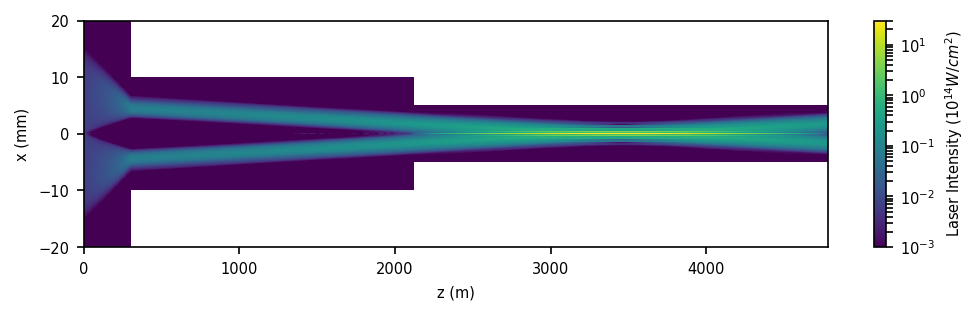

In [70]:
# For plotting we need a single grid to overlay images on
I0p = beam0.prep_data(I0)
I1p = beam1.prep_data(I1)
I2p = beam2.prep_data(I2)
Z = Z0+Z1+Z2
ext0 = [0, Z/1e3, -X0/2e3, X0/2e3]

I0m = np.zeros((int(Nx0*X0/X0), int(Nz0*Z/Z0)))
I0m = ma.asarray(I0m)
I0m[:, :] = ma.masked
I0m[:, :Nz0] = I0p

Nx = int(Nx1*X0/X1)
Nz = int(Nz1*Z/Z1)
I1m = np.zeros((int(Nx1*X0/X1), int(Nz1*Z/Z1)))
I1m = ma.asarray(I1m)
I1m[:, :] = ma.masked
I1m[int((Nx-Nx1)/2):int((Nx-Nx1)/2)+Nx1, int(Nz1*Z0/Z1):int(Nz1*Z0/Z1)+Nz1] = I1p

Nx = int(Nx2*X0/X2)
Nz = int(Nz2*Z/Z2)
I2m = np.zeros((int(Nx2*X0/X2), int(Nz2*Z/Z2)))
I2m = ma.asarray(I2m)
I2m[:, :] = ma.masked
I2m[int((Nx-Nx2)/2):int((Nx-Nx2)/2)+Nx2, int(Nz2*(Z0+Z1)/Z2):] = I2p

norm = colors.LogNorm(vmin=1e-3, vmax=30)
plt.figure(figsize=(8, 2), dpi=150)
plt.imshow(I0m, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel('z (m)')
plt.ylabel('x (mm)')
plt.show()

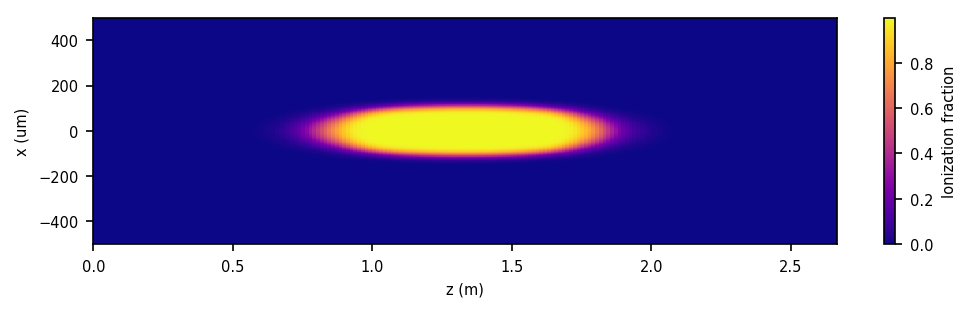

In [71]:
# Lets check the plasma density without refraction in He
atom = ionization.He
ne = adk.gaussian_frac(atom['EI'], abs(e2), tau, atom['Z'], atom['l'], atom['m'])
plt.figure(figsize=(8, 2), dpi=150)
plt.imshow(np.transpose(np.flipud(ne)), aspect='auto', extent=[0, Z2/1e6, -X2/2, X2/2], cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.ylim(-500, 500)
plt.xlabel(r'z (m)')
plt.ylabel(r'x (um)')
plt.show()

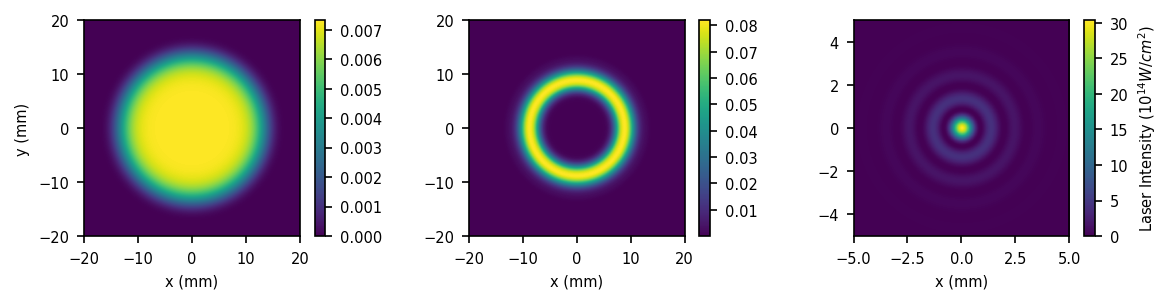

In [95]:
It0 = beam0.intensity_from_field(Et0)
It0 = beam0.prep_data(It0)
It1 = beam1.intensity_from_field(Et1)
It1 = beam1.prep_data(It1)
It2 = beam2.intensity_from_field(Et2)
It2 = beam2.prep_data(It2)

plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(131)
im = plt.imshow(It0, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
cb = plt.colorbar()
plt.xlabel(r'x (mm)')
plt.ylabel(r'y (mm)')

plt.subplot(132)
im = plt.imshow(It1, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
cb = plt.colorbar()
plt.xlabel(r'x (mm)')

plt.subplot(133)
im = plt.imshow(It2, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel(r'x (mm)')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.tight_layout()
plt.show()